## Final Assignment

### Introduction
In the past couple months, we’ve witnessed doctors, nurses, paramedics and thousands of medical workers putting their lives on the frontline to save patients who are infected. And as the battle with COVID-19 continues, we should all ask ourselves – What should we do to help out? What can we do to protect our loved ones, those who sacrifice for us, and ourselves from this pandemic?

### The question :

- **First :**
The first question is Which diet helps immunity against Corona?
- **Next :**  
whether there is a relationship between the protein levels and the fat levels of foods consumed by covid patients?
- **Finally :**
Which countries have a better diet? and Which countries have less confirmed covid patients?

### About Data:
This dataset selected from the kaggle website. (link mentioned)

https://www.kaggle.com/datasets/mariaren/covid19-healthy-diet-dataset?select=Food_Supply_Quantity_kg_Data.csv

In this dataset, I have combined data of different types of food, world population obesity and undernourished rate, and global COVID-19 cases count from around the world in order to learn more about how a healthy eating style could help combat the Corona Virus. And from the dataset, we can gather information regarding diet patterns from countries with lower COVID infection rate, and adjust our own diet accordingly.

In each of the 4 datasets below, I have calculated fat quantity, energy intake (kcal), food supply quantity (kg), and protein for different categories of food (all calculated as percentage of total intake amount). I've also added on the obesity and undernourished rate (also in percentage) for comparison. The end of the datasets also included the most up to date confirmed/deaths/recovered/active cases (also in percentage of current population for each country).

### Import needed Library

In [20]:
import pandas as pd
import numpy as np
import yaml
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.transform import dodge
from bokeh.models import TabPanel, Tabs
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

output_notebook() 

Loading BokehJS ...

### Load and select Data

In [21]:
# load data address from yaml file
def get_config():
    with open('config.yaml','r') as strem:
        config =yaml.safe_load(strem)
    return config

config = get_config()
fat = config['fat']
protein = config['protein']
cal = config['cal']
food = config['food']
geo = config['geo']

# load data from csv file
df_food = pd.read_csv(food)

# cut columns which are needed to analyze
df_food = df_food.iloc[: , :-3]
df_food.drop("Obesity", inplace=True, axis=1)
df_food.drop("Undernourished", inplace=True, axis=1)
df_food.drop("Deaths", inplace=True, axis=1)

# set contry column as index
df_food.set_index("Country",inplace=True)

# add calculated column which showing percentage recovered of confirmed patient
df_food['Recovered_P'] = df_food['Recovered']/df_food['Confirmed']

# load other file of dataset
df_fat = pd.read_csv(fat)
df_protein = pd.read_csv(protein)
df_geo = pd.read_csv(geo)

#### lets take a look at the data

In [22]:
# Monitoring Data
df_food.describe()
df_food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, Afghanistan to Zimbabwe
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alcoholic Beverages       170 non-null    float64
 1   Animal fats               170 non-null    float64
 2   Animal Products           170 non-null    float64
 3   Aquatic Products, Other   170 non-null    float64
 4   Cereals - Excluding Beer  170 non-null    float64
 5   Eggs                      170 non-null    float64
 6   Fish, Seafood             170 non-null    float64
 7   Fruits - Excluding Wine   170 non-null    float64
 8   Meat                      170 non-null    float64
 9   Milk - Excluding Butter   170 non-null    float64
 10  Miscellaneous             170 non-null    float64
 11  Offals                    170 non-null    float64
 12  Oilcrops                  170 non-null    float64
 13  Pulses                    170 non-null    float64
 14  

### Data Preproccessing

#### Noise Detection
As we know all values are between 0~100 so the value less than 0 and more than 100 is noise

In [23]:
# finding noise value
nc = []
for c in df_food.columns:
    if not df_food[((df_food[c]<0 )&(df_food[c]>100))].empty :
        nc.append(c)
        print(c,"has noise value")

if len(nc)==0:
    print("no noise detected")

no noise detected


#### Miss value detection
Finding miss values by 2 ways

In [24]:
# All column's sum of null value 
print(df_food.isnull().sum(axis = 0))

Alcoholic Beverages         0
Animal fats                 0
Animal Products             0
Aquatic Products, Other     0
Cereals - Excluding Beer    0
Eggs                        0
Fish, Seafood               0
Fruits - Excluding Wine     0
Meat                        0
Milk - Excluding Butter     0
Miscellaneous               0
Offals                      0
Oilcrops                    0
Pulses                      0
Spices                      0
Starchy Roots               0
Stimulants                  0
Sugar & Sweeteners          0
Sugar Crops                 0
Treenuts                    0
Vegetable Oils              0
Vegetables                  0
Vegetal Products            0
Confirmed                   6
Recovered                   6
Recovered_P                 6
dtype: int64


In [25]:
# finding all column null values
mc = []
for c in df_food.columns:
    if df_food[c].hasnans:
        mc.append(c)
        print(c,"has miss value")

if len(mc)==0:
    print("no miss value detected")

Confirmed has miss value
Recovered has miss value
Recovered_P has miss value


#### Miss value Management
The result shows there are few rows of data (only 6 rows) are missed. And we do not have any experts to fill in NA, so I decided to drop them

In [26]:
df_food=df_food.dropna(axis=0)
print(df_food.info())

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, Afghanistan to Zimbabwe
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alcoholic Beverages       164 non-null    float64
 1   Animal fats               164 non-null    float64
 2   Animal Products           164 non-null    float64
 3   Aquatic Products, Other   164 non-null    float64
 4   Cereals - Excluding Beer  164 non-null    float64
 5   Eggs                      164 non-null    float64
 6   Fish, Seafood             164 non-null    float64
 7   Fruits - Excluding Wine   164 non-null    float64
 8   Meat                      164 non-null    float64
 9   Milk - Excluding Butter   164 non-null    float64
 10  Miscellaneous             164 non-null    float64
 11  Offals                    164 non-null    float64
 12  Oilcrops                  164 non-null    float64
 13  Pulses                    164 non-null    float64
 14  

### Data Analysis
food_df contains the amount of each type of foods consumption. SO for answering the first question we should find the relation between each type of food values and patients.
- X for this question is Food category
- Y is 2 column 1.Number of confirmed patients 2.Number of Patients who were infected with corona and recovered

Now we find correlation between X and Y values to find which food category is more related to getting the disease and recovery

In [27]:
# define to list for saving the correlation data
conf_cor = []
recover_cor = []
foods = []
for c in df_food.columns[:-3]:
    conf_cor.append(df_food[c].corr(df_food['Confirmed']))
    recover_cor.append(df_food[c].corr(df_food['Recovered_P']))
    foods.append(c)

print(conf_cor)

[0.36437063581086504, 0.4869947845125498, 0.5932668656378756, -0.07418089995709683, -0.4429378673343376, 0.3521229218680846, -0.14144565213402974, -0.06698488154451848, 0.2957571876329153, 0.5829464128622668, -0.0670107996287466, -0.154201369132475, -0.24171168724546857, -0.3425779596152954, -0.1708564684871208, -0.3042113901731109, 0.2563227207462148, 0.2515628924736177, -0.14943702241711332, 0.16427518337851207, -0.0492931722263317, 0.1252643243208074, -0.5932729830177436]


#### Visualizing Data
for the finding result, use bar chart with 2 value for 2 Y

In [28]:
legends = ["Confirmed","Recovered"]

data = {'foods' : foods,
        'Confirmed' : conf_cor,
        'Recovered' : recover_cor,}

source = ColumnDataSource(data=data)

p = figure(x_range=foods, y_range=(-1, 1), title="Foods correlation with confirmed and recovered covid",
           height=350, toolbar_location=None, tools="")

p.vbar(x=dodge('foods', -0.25, range=p.x_range), top='Confirmed', source=source,
       width=0.2, color="#e84d60", legend_label="Confirmed")

p.vbar(x=dodge('foods',  0.0,  range=p.x_range), top='Recovered', source=source,
       width=0.2, color="#718dbf", legend_label="Recovered")


p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"
p.xaxis.major_label_orientation = "vertical"
p.width = 1000
p.height = 500

show(p)

#### Decision making
As chart shows we find 2 food categories with more relation
- Animal products (**possitive** correlation with **infection**) and (**negetive** correlation with **recovery**)
- Vegetal products (**negetive** correlation with **infection**) and (**possitive** correlation with **recovery**)

So for better understanding visual the sccater plot of 2 category with 2 Y values

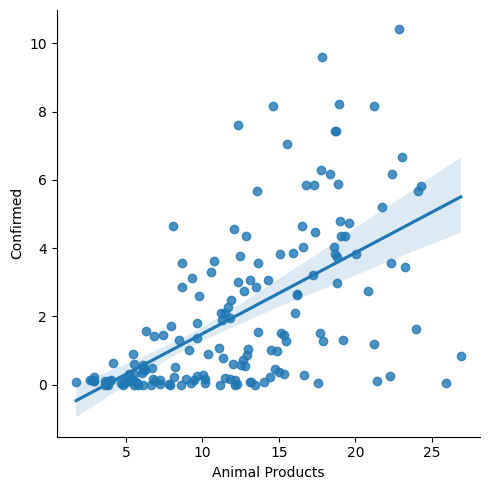

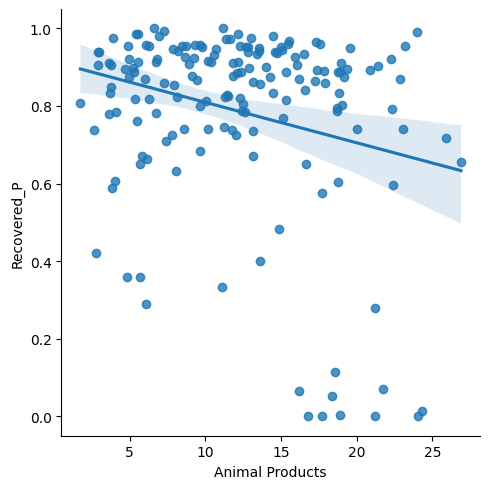

In [10]:

# plot sccater Animal products with Confirmed and Recovered
sns.lmplot(x="Animal Products", y="Confirmed" ,data= df_food)
sns.lmplot(x="Animal Products", y="Recovered_P" ,data= df_food)

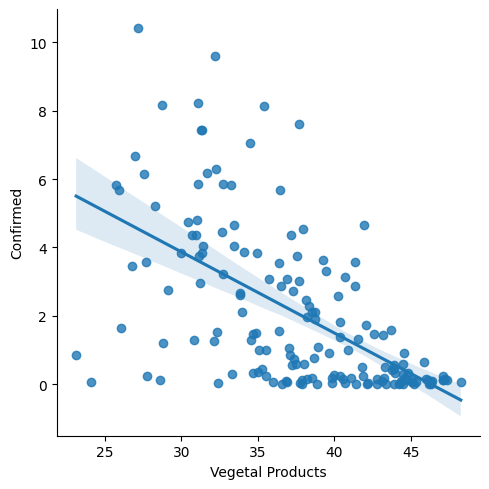

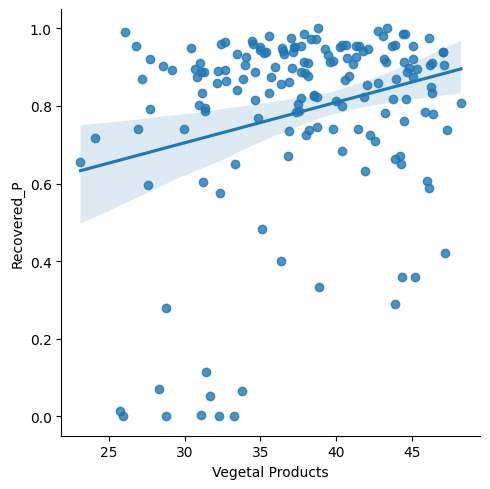

In [29]:
# plot sccater Vegetal products with Confirmed and Recovered
sns.lmplot(x="Vegetal Products", y="Confirmed" ,data= df_food)
sns.lmplot(x="Vegetal Products", y="Recovered_P" ,data= df_food)

#### Next steps of question
for the answering next step the question, I use only 2 most related category of food

##### Prepration Data
for the analyzing to factor (Fat, Protein) we should use the other data frame which are loaded at the loading data stage. So doing these steps
- select the needed data
- merge data frames to use

In [30]:
# select needed column of each dataset
df_food_cut = df_food.loc[:,['Animal Products','Vegetal Products','Confirmed','Recovered_P']]
df_fat_cut = df_fat.loc[:,['Country','Animal Products','Vegetal Products']]
df_protein_cut = df_protein.loc[:,['Country','Animal Products','Vegetal Products']]

# for use country field hace to reset the index (country was index in df_food)
df_food_cut = df_food_cut.rename_axis('Country').reset_index()

# before merging rename the columns
df_food_cut = df_food_cut.rename(columns={'Animal Products':'Animal Products_Amount', 'Vegetal Products':'Vegetal Products_Amount'})
df_fat_cut = df_fat_cut.rename(columns={'Animal Products':'Animal Products_fat', 'Vegetal Products':'Vegetal Products_fat'})
df_protein_cut = df_protein_cut.rename(columns={'Animal Products':'Animal Products_protein', 'Vegetal Products':'Vegetal Products_protein'})

# merging data frames
df_total = pd.merge(pd.merge(df_food_cut,df_fat_cut,on='Country',how='inner'),df_protein_cut,on='Country',how='inner')

# ordering columns
df_total = df_total.iloc[:,[0,1,2,5,6,7,8,3,4]]

print(df_total.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 163
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   164 non-null    object 
 1   Animal Products_Amount    164 non-null    float64
 2   Vegetal Products_Amount   164 non-null    float64
 3   Animal Products_fat       164 non-null    float64
 4   Vegetal Products_fat      164 non-null    float64
 5   Animal Products_protein   164 non-null    float64
 6   Vegetal Products_protein  164 non-null    float64
 7   Confirmed                 164 non-null    float64
 8   Recovered_P               164 non-null    float64
dtypes: float64(8), object(1)
memory usage: 12.8+ KB
None


##### Visualization
For 2 selected products I want to show relation between amount of each product with and Fat and Protein consumption  

In [31]:
fig1 = figure(height=500,title="Country usage")

fig1.xaxis.axis_label = "Country"
fig1.yaxis.axis_label = "value"

legend_labels = ['Amount','Fat','Protein']

# Amount line
fig1.line(df_total.index, df_total['Animal Products_Amount'], color = 'blue', legend_label = legend_labels[0], line_width=1.5)

# Fat line
fig1.line(df_total.index, df_total['Animal Products_fat'], color = 'red', legend_label = legend_labels[1], line_width=0.5, line_dash='dashed',line_alpha=0.5)

# Protein line
fig1.line(df_total.index, df_total['Animal Products_protein'], color = 'green', legend_label = legend_labels[2], line_width=0.5, line_dash='dashed',line_alpha=0.5)

tab1 = TabPanel(child=fig1, closable = True, title = "Animal Products")

fig2 = figure(height=500,title="Country usage")

fig2.xaxis.axis_label = "Country"
fig2.yaxis.axis_label = "value"

# Amount line
fig2.line(df_total.index, df_total['Vegetal Products_Amount'], color = 'blue', legend_label = legend_labels[0], line_width=1.5)

# Fat line
fig2.line(df_total.index, df_total['Vegetal Products_fat'], color = 'red', legend_label = legend_labels[1], line_width=0.5, line_dash='dashed',line_alpha=0.5)

# Protein line
fig2.line(df_total.index, df_total['Vegetal Products_protein'], color = 'green', legend_label = legend_labels[2], line_width=0.5, line_dash='dashed',line_alpha=0.5)

tab2 = TabPanel(child=fig2, closable = True, title = "Vegetal Products")
# Display
show(Tabs(tabs = [tab1, tab2]))



##### Decision making
In animal products The ratio of consumption with protein and fat is positive while in vegetal products this ratio is opposite

#### Finally
In order to find out which countries were infected with the corona disease and how much they used herbal products, I drew a thermal graph on the map.
- For drawing i need to have countries location so use df_geo and merge this with current data frame

In [32]:
# to find the location of each country i use df_geo 
df_total = pd.merge(df_total,df_geo,on='Country',how='inner')

In [33]:
map1 = folium.Map(location = [28.5011226, 77.4099794], zoom_start = 2)
HeatMap(
    data=list(zip(df_total['Latitude'],
                  df_total['Longitude'],
                  df_total['Confirmed'])
             )   ,
    radius   = 12
).add_to(map1)

map1

In [16]:
map2 = folium.Map(location = [28.5011226, 77.4099794], zoom_start = 2)
HeatMap(
    data=list(zip(df_total['Latitude'],
                  df_total['Longitude'],
                  df_total['Vegetal Products_Amount'])
             )   ,
    radius   = 12
).add_to(map2)
map2